..continuacion del cuadernillo anterior.
# Visualizacion de Precios

In [46]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas import DataFrame
import pandas as pd

sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(12,6))

#%%javascript
#IPython.OutputArea.auto_scroll_threshold = 9999;

shp_path = "./cl_regiones_geo/cl_regiones_geo.shp"
sf = shp.Reader(shp_path, encoding="ISO8859-1")

In [47]:
%run utils.py

import mysql.connector

password = ""
db_connection = mysql.connector.connect(user="root",host="localhost",password=password)
cursor = db_connection.cursor()

cursor.execute("use yapo2")

In [48]:
shp_path = "./cl_regiones_geo/cl_regiones_geo.shp"
sf = shp.Reader(shp_path, encoding="ISO8859-1")

In [49]:
sql = "select url,titulo,precio from anuncio where moneda = \"$\" and categoria = \"Arriendo - Departamento\" order by precio DESC;"
cursor.execute(sql)
df1 = DataFrame(cursor.fetchall())
df1.columns = cursor.column_names

## Distribucion de precios de la categoria "Arriendo - Departamento"

[]

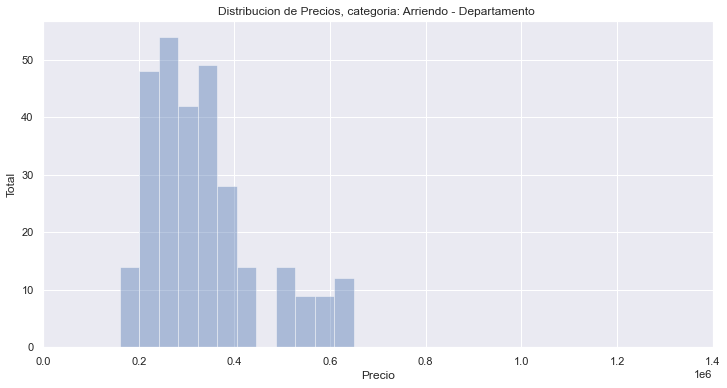

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

x = df1[9:]["precio"].to_numpy() 

sns.set(color_codes=True)

fig, ax = plt.subplots()
sns.distplot(x, kde=False, norm_hist=False)
ax.set_xlim(0,1400000)
ax.set_ylabel("Total")
ax.set_xlabel("Precio")
ax.set_title("Distribucion de Precios, categoria: Arriendo - Departamento ");
ax.plot()

## Precio Promedio de los arriendos por region

In [51]:
sql = "select nombre_region, avg(precio) as precio_prom from vendedor join anuncio using (id_vendedor) where categoria=\"Arriendo - Departamento\" and moneda=\"$\" and nombre_region != \"Ñuble\" and precio < 1500000 group by nombre_region order by precio_prom DESC;"
cursor.execute(sql)
df1 = DataFrame(cursor.fetchall())
df1.columns = cursor.column_names
df1["precio_prom"] = df1["precio_prom"].astype(int)
df1

,nombre_region,precio_prom
0,Antofagasta,550000
1,Araucanía,500000
2,Los Lagos,410000
3,Metropolitana,352958
4,Atacama,335000
5,Biobío,324615
6,Valparaíso,306000
7,Maule,302941
8,O'Higgins,160000


In [52]:
df1.loc[df1.nombre_region == "Metropolitana", "nombre_region"] = "Metropolitana de Santiago"
df1.loc[df1.nombre_region == "Valparaíso", "nombre_region"] = "Valparaiso"
df1.loc[df1.nombre_region == "Biobío", "nombre_region"] = "Biobio"
df1.loc[df1.nombre_region == "Magallanes & Antártica", "nombre_region"] = "Magallanes y de la Antartica Chileno"
df1.loc[df1.nombre_region == "Araucanía", "nombre_region"] = "La Araucania"
df1.loc[df1.nombre_region == "O'Higgins", "nombre_region"] = "Libertador Gral. Bernardo O'Higgins"
df1.loc[df1.nombre_region == "Los Ríos", "nombre_region"] = "Los Rios"
df1.loc[df1.nombre_region == "Tarapacá", "nombre_region"] = "Tarapaca"
df1.loc[df1.nombre_region == "Aisén", "nombre_region"] = "Aisen del Gral. Carlos Ibañez del Campo"
df1.loc[df1.nombre_region == "Arica & Parinacota", "nombre_region"] = "Arica y Parinacota"


1: 160000 => 303959 
2: 303960 => 318409 
3: 318410 => 334999 
4: 335000 => 371971 
5: 371972 => 469998 
6: 469999 => 549999 

   1   2   3   4   5   6


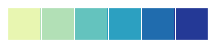

<Figure size 720x1800 with 0 Axes>

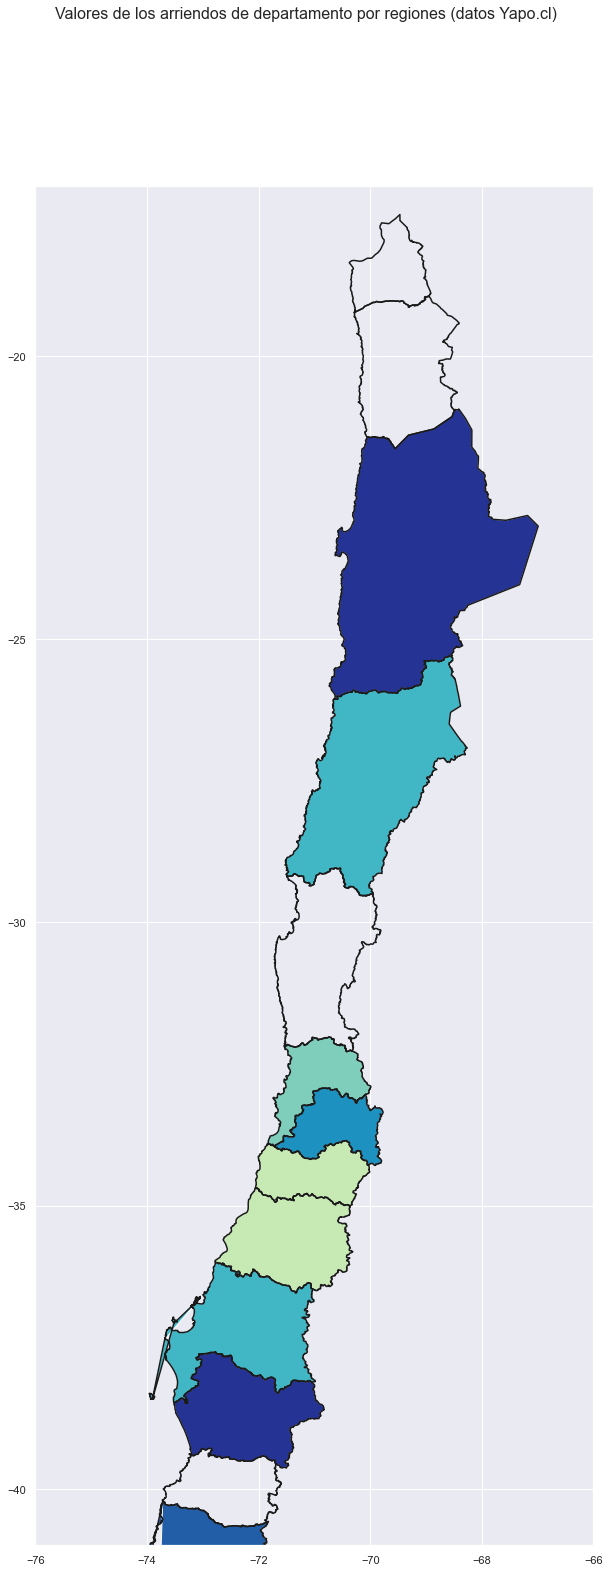

In [56]:
data = df1.precio_prom
regiones = df1.nombre_region

print_id = False # The shape id will be printed
color_pallete = 2
plot_regiones_data(sf, 'Valores de los arriendos de departamento por regiones (datos Yapo.cl)', regiones, data, color_pallete, print_id)

## Tratamiento del lenguaje, busqueda de palabras claves

In [59]:
import spacy
from collections import Counter
nlp = spacy.load('es_core_news_sm')
pd.set_option('display.max_colwidth', None)

In [60]:
query_categorias = '''select categoria from anuncio group by categoria''';
cursor.execute(query_categorias)
categorias = pd.DataFrame(cursor.fetchall())
categorias.columns = cursor.column_names
categorias
keywords = pd.DataFrame(columns = ["categoria", "keywords"])

In [61]:
indice_keywords = 0
for i in categorias['categoria'].iloc:
    ej_categoria = i

    query_anuncios = '''select titulo, descripcion from anuncio where categoria="{i_categoria}";'''.format(i_categoria=ej_categoria)
    cursor.execute(query_anuncios)
    anuncios = pd.DataFrame(cursor.fetchall())
    anuncios.columns = cursor.column_names
    
    text_acum = ""

    for index, row in anuncios.iterrows():
        titulo = row[0]
        descripcion = row[1]
        text_acum += titulo + ". ";

    doc = nlp(text_acum)

    words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    #nouns = [token.text for token in doc if token.is_stop != True and token.is_punct != True and token.pos_ == "NOUN"]

    word_freq = Counter(words)
    common_words = word_freq.most_common(10)

    keywords.loc[indice_keywords] = {"categoria": ej_categoria, "keywords": common_words}
    indice_keywords += 1

## 10 Palabras claves por categoria

In [62]:
keywords #tuplas ("elemento", "numero de veces")

,categoria,keywords
0,Otros artículos del hogar,"[(2, 18), (plazas, 14), (Lámpara, 9), (mesa, 9), (Grande, 9), (Cortina, 8), (baño, 8), (ganchos, 8), (Funda, 7), (plumón, 7)]"
1,Vendo - Terreno,"[(SITIO, 37), (Puchuncaví, 15), (PARCELA, 14), (Parcela, 13), (Longaví, 10), (AGRICOLA, 10), (Condominio, 9), (Brisas, 9), (Chicureo, 9), (Colina, 9)]"
2,Moda y vestuario,"[(talla, 29), (y, 17), (polerones, 16), (Chaquetas, 15), (Chaqueta, 12), (38, 10), (Jeans, 9), (Pantalón, 9), (Pantalon, 9), (elasticado, 9)]"
3,"Negocios, maquinaria y construcción","[(industrial, 14), (mm, 13), (Dispensador, 9), (papel, 9), (higienico, 9), (Soldadora, 9), (pvc, 9), (Herramientas, 9), (eléctrico, 9), (Taladro, 9)]"
4,Salud y belleza,"[(Mascarillas, 18), (Buzo, 9), (Overol, 9), (Papel, 9), (Polietileno, 9), (Cloro, 9), (Accu-chek, 8), (Cepillo, 6), (Alisador, 6), (3, 6)]"
5,Arriendo - Departamento,"[(Departamento, 164), (San, 81), (Metro, 54), (Santiago, 52), (DEPARTAMENTO, 49), (Depto, 34), (2, 31), (Condes, 28), (Miguel, 27), (Santa, 21)]"
6,Arriendo - Oficina,"[(Oficina, 14), (Amplia, 9), (y, 9), (Cómoda, 9), (Raul, 9), (Labbé, 9), (Barnechea, 9), (Huerfanos, 5), (757, 5), (2, 5)]"
7,"Autos, camionetas y 4x4","[(prenda, 134), (Busco, 128), (vehículos, 114), ( , 65), (Full, 42), (2018, 42), (Kia, 40), (o, 37), (Ford, 34), (Chevrolet, 33)]"
8,Vendo - Casa,"[(CASA, 43), (Casa, 19), (San, 16), (Condominio, 11), (sector, 9), (PARQUE, 9), (COUSIÑO, 9), (MACUL, 9), (VALLES, 9), (Peñalolén, 9)]"
9,Vendo - Departamento,"[(DEPARTAMENTO, 62), (Departamento, 38), (Antofagasta, 35), (departamento, 21), (Excelente, 16), (centro, 16), (SUR, 9), (LLACOLEN, 9), (puerto, 9), (velero, 9)]"


In [63]:
query_regiones = '''select nombre_region from vendedor group by nombre_region;'''
cursor.execute(query_regiones)
regiones = pd.DataFrame(cursor.fetchall())
regiones.columns = cursor.column_names
regiones
keywords_regiones = pd.DataFrame(columns = ["nombre_region", "keywords"])

In [67]:
n_palabras_claves = 2
indice_kw_regiones = 0
for i in regiones['nombre_region'].iloc:
    ej_region = i

    query_anuncios = '''select titulo from anuncio join vendedor using (id_vendedor) where nombre_region="{i_region}";'''.format(i_region=ej_region)
    cursor.execute(query_anuncios)
    anuncios = pd.DataFrame(cursor.fetchall())
    anuncios.columns = cursor.column_names
    
    text_acum = ""

    for index, row in anuncios.iterrows():
        titulo = row[0]
        text_acum += titulo + ". ";

    doc = nlp(text_acum)

    words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    #nouns = [token.text for token in doc if token.is_stop != True and token.is_punct != True and token.pos_ == "NOUN"]

    word_freq = Counter(words)
    common_words = word_freq.most_common(n_palabras_claves) #

    keywords_regiones.loc[indice_kw_regiones] = {"nombre_region": ej_region, "keywords": common_words}
    indice_kw_regiones += 1

## Palabra clave por region

In [68]:
keywords_regiones #tuplas ("elemento", "numero de veces")

,nombre_region,keywords
0,Metropolitana,"[(Departamento, 157), (Busco, 120)]"
1,Biobío,"[(Set, 21), (o, 20)]"
2,Araucanía,"[(Ford, 13), (DEPARTAMENTO, 9)]"
3,Valparaíso,"[(Puchuncaví, 25), (SITIO, 15)]"
4,Antofagasta,"[(Antofagasta, 37), (DEPARTAMENTO, 33)]"
5,Maule,"[(Departamento, 13), (Longaví, 10)]"
6,Atacama,"[(Busco, 5), (casa, 5)]"
7,Magallanes & Antártica,"[(2, 14), (varón, 14)]"
8,O'Higgins,"[(Trompeta, 9), (mandala, 9)]"
9,Coquimbo,"[(DEPARTAMENTO, 9), (puerto, 9)]"


## A partir de los datos obtenidos:
* Proponemos un análisis orientado a sistemas, en el cual podriamos tomar como datos las categorias o las regiones y usar algun tipo de modelo de aprendizaje automático no supervisado para encontrar clusteres o patrones mas complejos que simplemente las palabras claves. Asi tendriamos una vision diferente y menos intuitiva de la actividad económica durantes este periodo de covid. Y podriamos proponer mejores soluciones en base a las necesidades del pais.